In [1]:
from pyro import distributions as dist
import torch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from glob import glob
from src.usflows.explib.config_parser import from_checkpoint
from src.usflows.explib.eval import RadialFlowEvaluator
import os
from src.usflows.distributions import Chi
from src.usflows.explib.datasets import DistributionDataset
from src.usflows.distributions import GMM
from torch.nn.functional import softplus

# Evaluate all Dims

['/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/0_gaussian_mixture_2D', '/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/1_gaussian_mixture_8D', '/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/2_gaussian_mixture_32D', '/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/3_gaussian_mixture_128D']
/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/0_gaussian_mixture_2D
2D GMM
/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/1_gaussian_mixture_8D
8D GMM


/home/faried/Projects/USFlows/src/usflows/explib/config_parser.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict)


/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/2_gaussian_mixture_32D
32D GMM


/home/faried/Projects/USFlows/src/usflows/explib/config_parser.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict)


/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us/3_gaussian_mixture_128D
128D GMM


/home/faried/Projects/USFlows/src/usflows/explib/config_parser.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict)


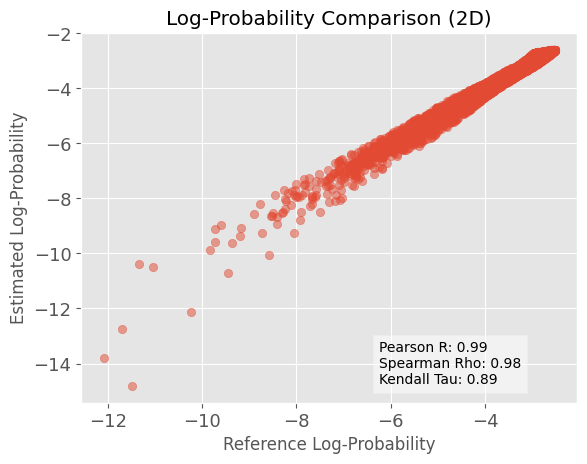

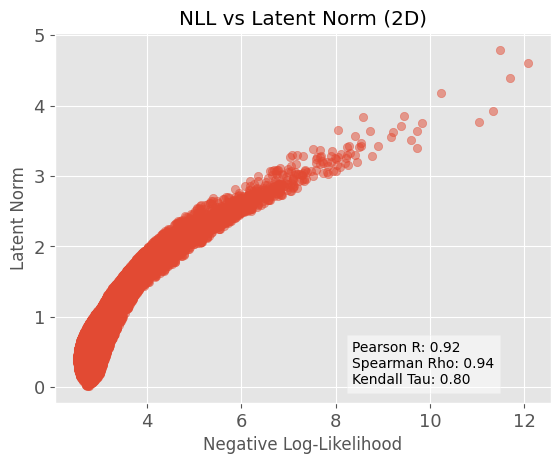

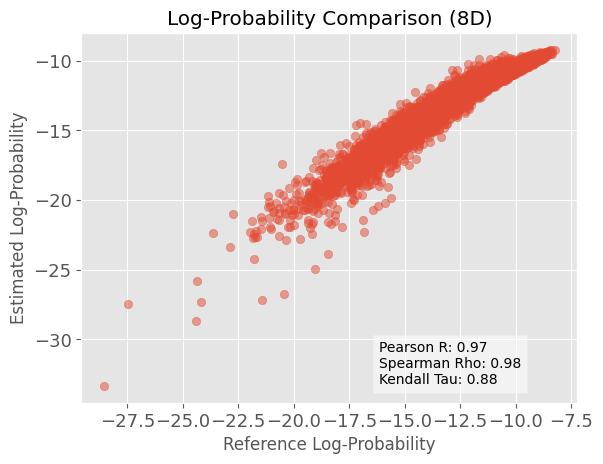

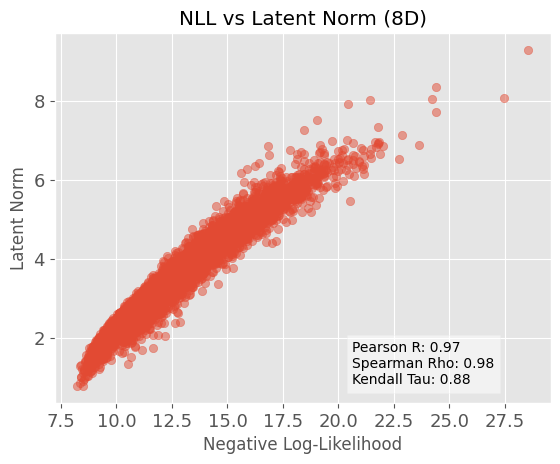

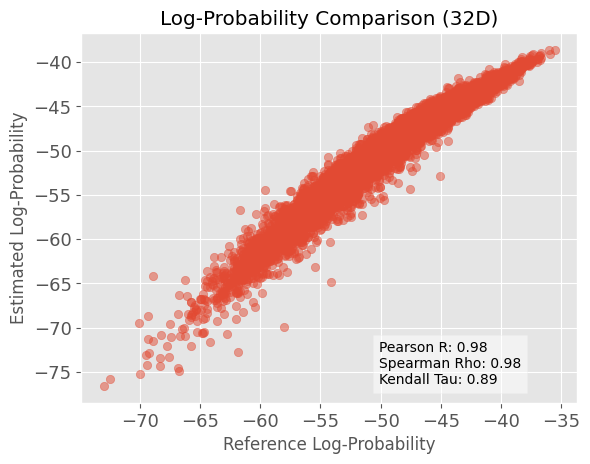

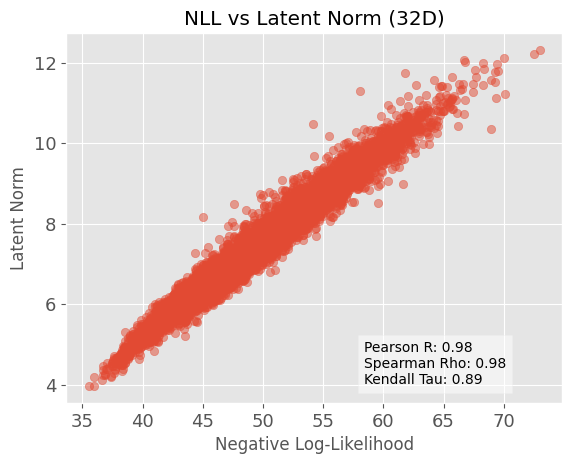

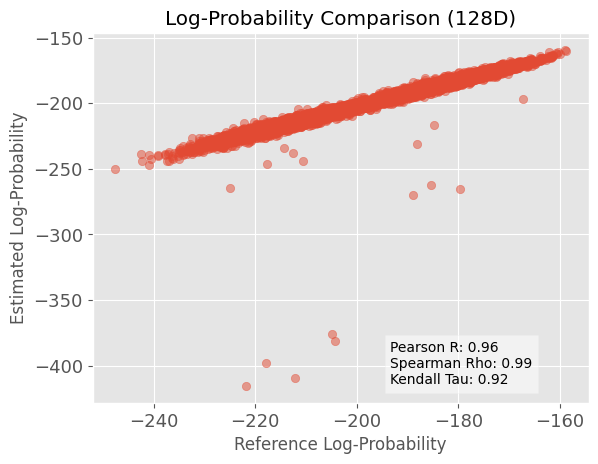

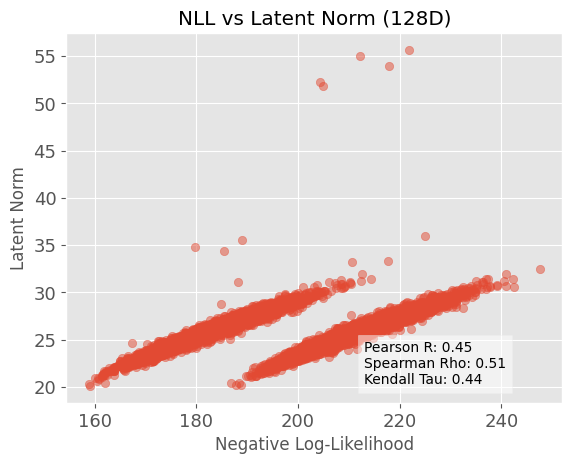

In [20]:
arch = "Non-US"
base_dir = "/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/non-us"
#base_dir = "/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments"
subfolders = sorted(os.listdir(base_dir))
subfolders = [os.path.join(base_dir, d) for d in subfolders]
subfolders = sorted([d for d in subfolders if os.path.isdir(d)])

model_dirs = [
    os.path.join(base_dir, subfolder) for subfolder in subfolders if os.path.isdir(os.path.join(base_dir, subfolder))
]

# fig, axes = plt.subplots(1, int(len(model_dirs)), figsize=(5*len(model_dirs), 6))
data = {}
print(model_dirs)
for i, model_dir in enumerate(model_dirs):
    print(model_dir)
    # Locate model files
    pkl_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".pkl")])
    pt_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".pt")])

    if not pkl_files or not pt_files:
        print(f"Skipping {model_dir} (missing files)")
        continue

    pkl_path = os.path.join(model_dir, pkl_files[-1])
    pt_path = os.path.join(model_dir, pt_files[-1])
    try:
        model = from_checkpoint(pkl_path, pt_path)
    except:
        continue
        
    dim = int(model_dir.split("_")[-1][:-1])
    #dim = int(model_dir.split("_")[-1][:-1])
    print(f"{dim}D GMM")
    hdim = int(dim/2)
    distribution=GMM(
        loc=torch.stack([-torch.ones(dim), torch.ones(dim)]), 
        covariance_matrix=torch.stack([
            torch.diag(torch.tensor([5.]*hdim + [.5]*hdim)), 
            torch.eye(dim)
        ]),
        mixture_weights=torch.ones(2)/2
    )
    ref_dist = distribution
    
    ds = DistributionDataset(
        distribution=distribution,
        num_samples=10000
    )[:][0]
    
    #threshold = ref_dist.log_prob(ds).sort()[0][2500]
    #ds = ds[ref_dist.log_prob(ds) < threshold]
    data[i] = ds

    evaluator = RadialFlowEvaluator(
        model,
        ds,
        p=2.0,
        norm_distribution=Chi(
            df=dim,
            scale=softplus(model.base_distribution.scale_unconstrained),
            validate_args=False
        )
    )

    row = i
    col = 0
    
    
    
    #evaluator.kde_plot_norms(ax=axes[row, col + 1])
    #axes[row, col + 1].set_title(f"KDE of Norm Distributions ({dim}D)")
    #axes[row, col + 1].legend(loc = 'upper right')
    #evaluator.pp_plot_norms(ax=axes[row, col + 2])
    #axes[row, col + 2].set_title(f"PP-plot of Norm Distributions ({dim}D)")
    #evaluator.logprob_reference_scatter_plot(ax=axes[row, col + 0], ref_distribution=ref_dist)
    #axes[row, col + 0].set_title(f"Log-Probability Comparison ({dim}D)")
    scatter_fig, ax = plt.subplots()
    evaluator.logprob_reference_scatter_plot(ax=ax, ref_distribution=ref_dist)
    ax.set_title(f"Log-Probability Comparison ({dim}D)")
    scatter_fig.savefig(f"gmm_eval_logprobs_{dim}D_{arch}.png")
    
    scatter_fig, ax = plt.subplots()
    evaluator.nll_norm_scatter_plot(ax=ax, ref_distribution=ref_dist)
    ax.set_title(f"NLL vs Latent Norm ({dim}D)")
    scatter_fig.savefig(f"gmm_eval_nll_vs_latent_norms_{dim}D_{arch}.png")

plt.show()    

# Eval 2D

In [21]:
from matplotlib.patches import Circle

#base_path = "/home/faried/ray_results/_trial_2025-09-09_11-00-12/_trial_652c1_00000_0_batch_size=32,hidden_dims=64_32,coupling_blocks=6,nonlinearity=ref_ph_842f7f0d,soft_training=False_2025-09-09_11-00-12"
#base_path = "/home/faried/Projects/USFlows/reports/gaussian_mixture_experiments/0_gaussian_mixture_2D"
base_path =  base_dir + "/0_gaussian_mixture_2D"

pkl_path = sorted(glob(f"{base_path}/*.pkl"))[-1]
pt_path = sorted(glob(f"{base_path}/*.pt"))[-1]

dim = 2
distribution=GMM(
    loc=torch.stack([-torch.ones(dim), torch.ones(dim)]), 
    covariance_matrix=torch.stack([torch.diag(torch.Tensor([5., .5])) ,torch.eye(dim)]),
    #covariance_matrix=torch.stack([torch.eye(dim)] * 2),
    mixture_weights=torch.ones(2)/2
)
ref_dist = distribution

model = from_checkpoint(pkl_path, pt_path)

with torch.no_grad():
    ds = distribution.sample([1000])
    latents = model.backward(ds) - model.base_distribution.loc

/home/faried/Projects/USFlows/src/usflows/explib/config_parser.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict)


## Plot Determinant

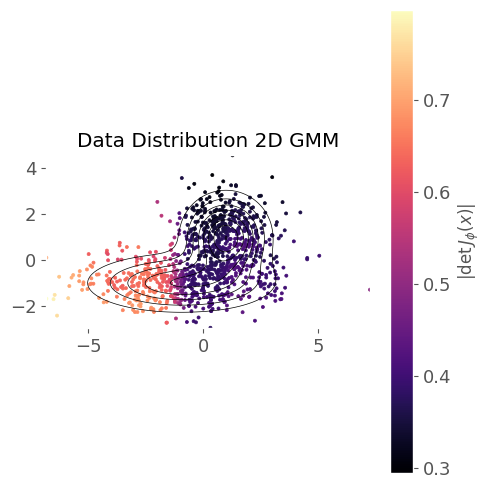

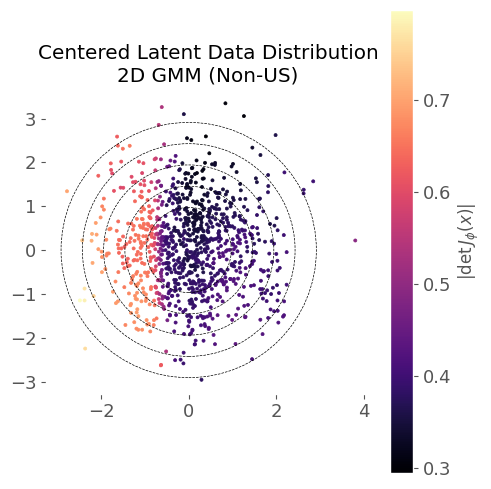

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

_, ax = plt.subplots(figsize=(5, 5))
ax.set_facecolor('white')

ax
# 1. Generate sample data (replace with your dataset)
np.random.seed(42)
x = ds[:, 0].numpy()
y = ds[:, 1].numpy()

# 2. Create grid for density evaluation
x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# 3. Calculate density using Kernel Density Estimation (KDE)

density = np.reshape(torch.exp(ref_dist.log_prob(torch.Tensor(positions).permute(1,0))).detach().T, x_grid.shape)


# Contour lines only
contour = ax.contour(x_grid, y_grid, density, levels=8, colors='black', linewidths=0.5)

# Filled contours with colormap
#contourf = plt.contourf(x_grid, y_grid, density, levels=32, cmap='viridis')

# Add colorbar
#cbar = plt.colorbar(contourf)
#cbar.set_label('Density')

# Add data points overlay (optional)
with torch.no_grad():
    #c = torch.exp(distribution.log_prob(ds))
    c = torch.exp(model.log_abs_det_jacobian(ds))
    if c.dim() == 0:
        c = [c] * len(ds)
scatter = ax.scatter(x, y, s=5, c=c, cmap="magma", alpha=1)
plt.colorbar(scatter, label='$|\\det J_{\\phi}(x)|$')

# Customize plot
ax.set_title('Data Distribution 2D GMM')
#ax.xlabel('X-axis')
#ax.ylabel('Y-axis')
ax.set_aspect('equal')
ax.grid(alpha=0.2)
plt.tight_layout()

plt.savefig(f"contour_2d_gmm_{arch}_log_abs_det_jac.png")

###############################################3

_, ax = plt.subplots(figsize=(5, 5))
ax.set_facecolor('white')

# 1. Generate sample data (replace with your dataset)
np.random.seed(42)
x = latents[:, 0].numpy()
y = latents[:, 1].numpy()

# 2. Create grid for density evaluation
x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# 3. Calculate density using Kernel Density Estimation (KDE)
kde = gaussian_kde(np.vstack([x, y]))
#density = np.reshape(kde(positions).T, x_grid.shape)


# Contour lines only
#contour = ax.contour(x_grid, y_grid, density, levels=8, colors='black', linewidths=0.5)

# Filled contours with colormap
#contourf = plt.contourf(x_grid, y_grid, density, levels=32, cmap='viridis')

# Add colorbar
#cbar = plt.colorbar(contourf)
#cbar.set_label('Density')

# Add data points overlay (optional)

scatter = ax.scatter(x, y, s=5, c=c, cmap="magma", alpha=1)
plt.colorbar(scatter, label='$|\\det J_{\\phi}(x)|$')

# Customize plot
ax.set_title(f'Centered Latent Data Distribution\n2D GMM ({arch})')

#ax.xlabel('X-axis')
#ax.ylabel('Y-axis')
scale = softplus(model.base_distribution.scale_unconstrained)
ax.add_patch(Circle((0., 0.), radius=scale, fill=False, edgecolor='black', linewidth=.5, linestyle='--'))
ax.add_patch(Circle((0., 0.), radius=1.5*scale, fill=False, edgecolor='black', linewidth=.5, linestyle='--'))
ax.add_patch(Circle((0., 0.), radius=2*scale, fill=False, edgecolor='black', linewidth=.5 , linestyle='--'))
ax.add_patch(Circle((0., 0.), radius=2.5*scale, fill=False, edgecolor='black', linewidth=.5, linestyle="--"))
ax.add_patch(Circle((0., 0.), radius=3*scale, fill=False, edgecolor='black', linewidth=.5, linestyle="--"))
ax.set_aspect('equal')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(f"contour_latent_2d_gmm_{arch}_log_abs_det_jac.png")

plt.show()

## Plot Densities

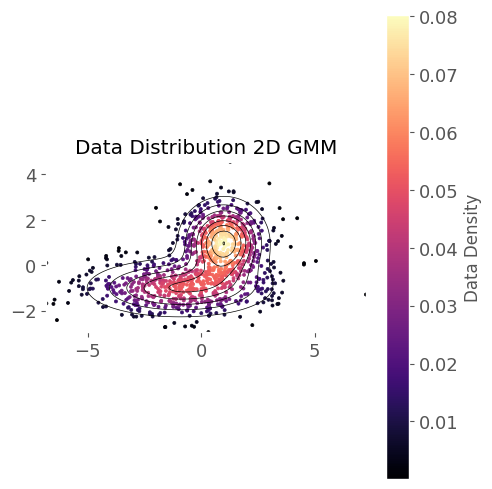

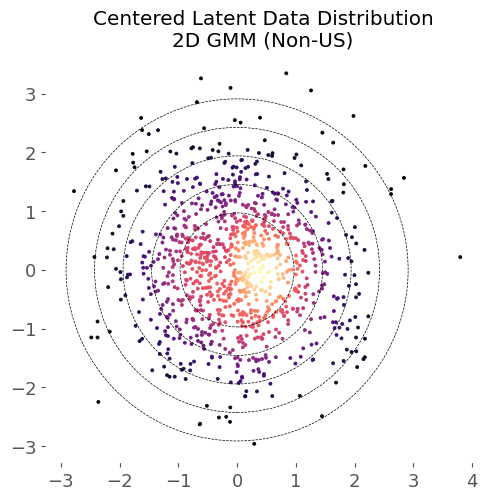

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

_, ax = plt.subplots(figsize=(5, 5))
ax.set_facecolor('white')

ax
# 1. Generate sample data (replace with your dataset)
np.random.seed(42)
x = ds[:, 0].numpy()
y = ds[:, 1].numpy()

# 2. Create grid for density evaluation
x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# 3. Calculate density using Kernel Density Estimation (KDE)

density = np.reshape(torch.exp(ref_dist.log_prob(torch.Tensor(positions).permute(1,0))).detach().T, x_grid.shape)


# Contour lines only
contour = ax.contour(x_grid, y_grid, density, levels=8, colors='black', linewidths=0.5)

# Filled contours with colormap
#contourf = plt.contourf(x_grid, y_grid, density, levels=32, cmap='viridis')

# Add colorbar
#cbar = plt.colorbar(contourf)
#cbar.set_label('Density')

# Add data points overlay (optional)
with torch.no_grad():
    c = torch.exp(distribution.log_prob(ds))
    #c = torch.exp(model.log_abs_det_jacobian(ds))
scatter = ax.scatter(x, y, s=5, c=c, cmap="magma", alpha=1)
plt.colorbar(scatter, label='Data Density')

# Customize plot
ax.set_title('Data Distribution 2D GMM')
#ax.xlabel('X-axis')
#ax.ylabel('Y-axis')
ax.set_aspect('equal')
ax.grid(alpha=0.2)
plt.tight_layout()

plt.savefig(f"contour_2d_gmm_{arch}_density.png")

###############################################3

_, ax = plt.subplots(figsize=(5, 5))
ax.set_facecolor('white')

# 1. Generate sample data (replace with your dataset)
np.random.seed(42)
x = latents[:, 0].numpy()
y = latents[:, 1].numpy()

# 2. Create grid for density evaluation
x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# 3. Calculate density using Kernel Density Estimation (KDE)
kde = gaussian_kde(np.vstack([x, y]))
#density = np.reshape(kde(positions).T, x_grid.shape)


# Contour lines only
#contour = ax.contour(x_grid, y_grid, density, levels=8, colors='black', linewidths=0.5)

# Filled contours with colormap
#contourf = plt.contourf(x_grid, y_grid, density, levels=32, cmap='viridis')

# Add colorbar
#cbar = plt.colorbar(contourf)
#cbar.set_label('Density')

# Add data points overlay (optional)

scatter = ax.scatter(x, y, s=5, c=c, cmap="magma", alpha=1)
#plt.colorbar(scatter, label='Data Density')

# Customize plot
ax.set_title(f'Centered Latent Data Distribution\n2D GMM ({arch})')

#ax.xlabel('X-axis')
#ax.ylabel('Y-axis')
ax.add_patch(Circle((0., 0.), radius=scale, fill=False, edgecolor='black', linewidth=.5, linestyle='--'))
ax.add_patch(Circle((0., 0.), radius=1.5*scale, fill=False, edgecolor='black', linewidth=.5, linestyle='--'))
ax.add_patch(Circle((0., 0.), radius=2*scale, fill=False, edgecolor='black', linewidth=.5 , linestyle='--'))
ax.add_patch(Circle((0., 0.), radius=2.5*scale, fill=False, edgecolor='black', linewidth=.5, linestyle="--"))
ax.add_patch(Circle((0., 0.), radius=3*scale, fill=False, edgecolor='black', linewidth=.5, linestyle="--"))
ax.set_aspect('equal')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(f"contour_latent_2d_gmm_{arch}_density.png")

plt.show()